# Tutorial: # NLP (Natural Language Processing) with Python

***
### **I hope you find this kernel useful and your <font color="red"><b>UPVOTES</b></font> would be highly appreciated**
***

## Agenda

1. Representing text as numerical data
2. Reading a text-based dataset into pandas
3. Vectorizing our dataset
4. Building and evaluating a model
5. Comparing models
6. Examining a model for further insight
7. Practicing this workflow on another dataset
8. Tuning the vectorizer (discussion)


In this notebook we will discuss a higher level overview of the basics of Natural Language Processing, which basically consists of combining machine learning techniques with text, and using math and statistics to get that text in a format that the machine learning algorithms can understand!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

# 1. Representing text as numerical data

In [2]:
# example text for model training (SMS messages)
simple_train = ['call you tonight', 'Call me a cab', 'Please call me... PLEASE!']

From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect **numerical feature vectors with a fixed size** rather than the **raw text documents with variable length**.

We will use [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to "convert text into a matrix of token counts":

In [3]:
# import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [4]:
# learn the 'vocabulary' of the training data (occurs in-place)
vect.fit(simple_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [5]:
# examine the fitted vocabulary
vect.get_feature_names()

['cab', 'call', 'me', 'please', 'tonight', 'you']

In [6]:
# transform training data into a 'document-term matrix'
simple_train_dtm = vect.transform(simple_train)
simple_train_dtm

<3x6 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [7]:
# convert sparse matrix to a dense matrix
simple_train_dtm.toarray()

array([[0, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [0, 1, 1, 2, 0, 0]], dtype=int64)

In [8]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(simple_train_dtm.toarray(), columns=vect.get_feature_names())

,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,2,0,0


From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> In this scheme, features and samples are defined as follows:

> - Each individual token occurrence frequency (normalized or not) is treated as a **feature**.
> - The vector of all the token frequencies for a given document is considered a multivariate **sample**.

> A **corpus of documents** can thus be represented by a matrix with **one row per document** and **one column per token** (e.g. word) occurring in the corpus.

> We call **vectorization** the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the **Bag of Words** or "Bag of n-grams" representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

In [9]:
# check the type of the document-term matrix
type(simple_train_dtm)

scipy.sparse.csr.csr_matrix

In [10]:
# examine the sparse matrix contents
print(simple_train_dtm)

  (0, 1)	1
  (0, 4)	1
  (0, 5)	1
  (1, 0)	1
  (1, 1)	1
  (1, 2)	1
  (2, 1)	1
  (2, 2)	1
  (2, 3)	2


From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> As most documents will typically use a very small subset of the words used in the corpus, the resulting matrix will have **many feature values that are zeros** (typically more than 99% of them).

> For instance, a collection of 10,000 short text documents (such as emails) will use a vocabulary with a size in the order of 100,000 unique words in total while each document will use 100 to 1000 unique words individually.

> In order to be able to **store such a matrix in memory** but also to **speed up operations**, implementations will typically use a **sparse representation** such as the implementations available in the `scipy.sparse` package.

In [11]:
# example text for model testing
simple_test = ["please don't call me"]

In order to **make a prediction**, the new observation must have the **same features as the training observations**, both in number and meaning.

In [12]:
# transform testing data into a document-term matrix (using existing vocabulary)
simple_test_dtm = vect.transform(simple_test)
simple_test_dtm.toarray()

array([[0, 1, 1, 1, 0, 0]], dtype=int64)

In [13]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(simple_test_dtm.toarray(), columns=vect.get_feature_names())

,cab,call,me,please,tonight,you
0,0,1,1,1,0,0


**Summary:**

- `vect.fit(train)` **learns the vocabulary** of the training data

- `vect.transform(train)` uses the **fitted vocabulary** to build a document-term matrix from the training data

- `vect.transform(test)` uses the **fitted vocabulary** to build a document-term matrix from the testing data (and **ignores tokens** it hasn't seen before)

# 2. Reading a text-based dataset into pandas

In [14]:
# read file into pandas using a relative path
# sms = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding='latin-1', names=['label', 'message'])
# sms.dropna(how="any", inplace=True, axis=1)
sms = pd.read_csv('data/sms.tsv', delimiter='\t', names=['label', 'message'])
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# 3. Exploratory Data Analysis (EDA)

In [15]:
sms.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [16]:
sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

We have `4825` ham message and `747` spam message

In [17]:
# convert label to a numerical variable
sms['label_num'] = sms.label.map({'ham':0, 'spam':1})
sms.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of feature engineering. The better your domain knowledge on the data, the better your ability to engineer more features from it. Feature engineering is a very large part of spam detection in general.

In [18]:
sms['message_len'] = sms.message.apply(len)
sms.head()

,label,message,label_num,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


Text(0.5, 0, 'Message Length')

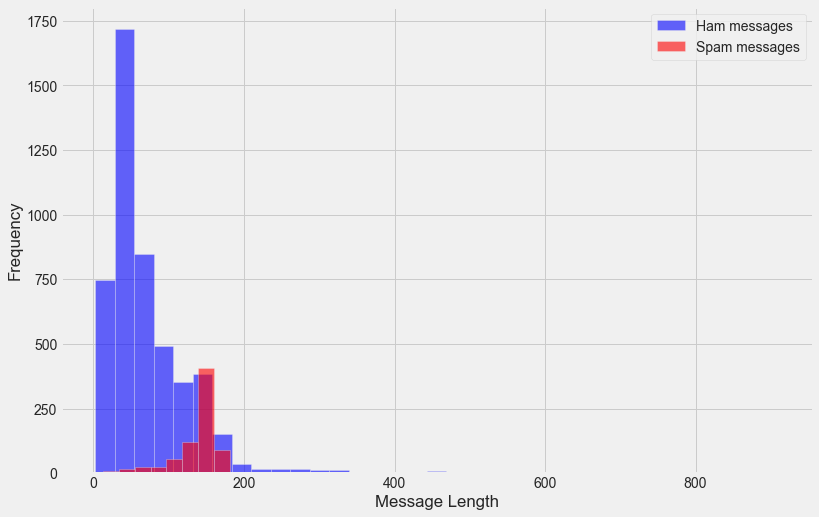

In [19]:
plt.figure(figsize=(12, 8))

sms[sms.label=='ham'].message_len.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
sms[sms.label=='spam'].message_len.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

Very interesting! Through just basic EDA we've been able to discover a trend that spam messages tend to have more characters.

In [20]:
sms[sms.label=='ham'].describe()

,label_num,message_len
count,4825.0,4825.000000
mean,0.0,71.482902
std,0.0,58.442635
min,0.0,2.000000
25%,0.0,33.000000
50%,0.0,52.000000
75%,0.0,93.000000
max,0.0,910.000000


In [21]:
sms[sms.label=='spam'].describe()

,label_num,message_len
count,747.0,747.000000
mean,1.0,138.670683
std,0.0,28.873603
min,1.0,13.000000
25%,1.0,133.000000
50%,1.0,149.000000
75%,1.0,157.000000
max,1.0,223.000000


Woah! 910 characters, let's use masking to find this message:

In [22]:
sms[sms.message_len == 910].message.iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

# 4. Text Pre-processing

Our main issue with our data is that it is all in text format (strings). The classification algorithms that we usally use need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the `bag-of-words` approach, where each unique word in a text will be represented by one number.


In this section we'll convert the raw messages (sequence of characters) into vectors (sequences of numbers).

As a first step, let's write a function that will split a message into its individual words and return a list. We'll also remove very common words, ('the', 'a', etc..). To do this we will take advantage of the `NLTK` library. It's pretty much the standard library in Python for processing text and has a lot of useful features. We'll only use some of the basic ones here.

Let's create a function that will process the string in the message column, then we can just use **apply()** in pandas do process all the text in the DataFrame.

First removing punctuation. We can just take advantage of Python's built-in **string** library to get a quick list of all the possible punctuation:

In [23]:
import string
from nltk.corpus import stopwords

def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

In [24]:
sms.head()

,label,message,label_num,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


Now let's "tokenize" these messages. Tokenization is just the term used to describe the process of converting the normal text strings in to a list of tokens (words that we actually want).

In [25]:
sms['clean_msg'] = sms.message.apply(text_process)

In [26]:
sms.head()

,label,message,label_num,message_len,clean_msg
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,29,Ok lar Joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,Free entry wkly comp win FA Cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,0,49,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,Nah think goes usf lives around though


In [27]:
type(stopwords.words('english'))

list

In [28]:
from collections import Counter

words = sms[sms.label=='ham'].clean_msg.apply(lambda x: [word.lower() for word in x.split()])
ham_words = Counter()

for msg in words:
    ham_words.update(msg)
    
print(ham_words.most_common(50))

[('get', 303), ('ltgt', 276), ('ok', 273), ('go', 250), ('ill', 238), ('got', 232), ('know', 232), ('like', 231), ('call', 231), ('come', 227), ('good', 224), ('love', 190), ('time', 189), ('day', 188), ('going', 167), ('want', 164), ('one', 163), ('home', 160), ('lor', 160), ('need', 157), ('sorry', 153), ('still', 147), ('see', 138), ('n', 137), ('later', 134), ('da', 131), ('r', 131), ('back', 129), ('think', 128), ('well', 127), ('today', 125), ('send', 123), ('tell', 121), ('cant', 119), ('hi', 117), ('take', 112), ('oh', 112), ('much', 112), ('night', 109), ('happy', 106), ('hey', 106), ('great', 100), ('way', 100), ('hope', 100), ('pls', 98), ('work', 97), ('wat', 95), ('thats', 95), ('give', 94), ('dear', 94)]


In [29]:
words = sms[sms.label=='spam'].clean_msg.apply(lambda x: [word.lower() for word in x.split()])
spam_words = Counter()

for msg in words:
    spam_words.update(msg)
    
print(spam_words.most_common(50))

[('call', 347), ('free', 216), ('txt', 150), ('mobile', 123), ('text', 120), ('stop', 115), ('claim', 113), ('reply', 101), ('prize', 92), ('get', 83), ('new', 69), ('send', 68), ('nokia', 65), ('urgent', 63), ('cash', 62), ('win', 60), ('contact', 56), ('service', 55), ('please', 52), ('16', 51), ('guaranteed', 50), ('customer', 49), ('week', 49), ('tone', 48), ('per', 46), ('phone', 45), ('18', 43), ('chat', 42), ('awarded', 38), ('draw', 38), ('latest', 36), ('£1000', 35), ('line', 35), ('150ppm', 34), ('mins', 34), ('receive', 33), ('camera', 33), ('1', 33), ('box', 33), ('every', 33), ('message', 32), ('po', 32), ('holiday', 32), ('landline', 32), ('shows', 31), ('£2000', 31), ('go', 31), ('number', 30), ('apply', 29), ('code', 29)]


## Vectorization

Currently, we have the messages as lists of tokens (also known as [lemmas](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

We'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)
2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)
3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin the first step:

Each vector will have as many dimensions as there are unique words in the SMS corpus.  We will first use SciKit Learn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message. 

For example:

<table border = “1“>
<tr>
<th></th> <th>Message 1</th> <th>Message 2</th> <th>...</th> <th>Message N</th> 
</tr>
<tr>
<td><b>Word 1 Count</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word 2 Count</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word N Count</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>


Since there are so many messages, we can expect a lot of zero counts for the presence of that word in that document. Because of this, SciKit Learn will output a [Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix).

In [30]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
X = sms.clean_msg
y = sms.label_num
print(X.shape)
print(y.shape)

(5572,)
(5572,)


In [31]:
# split X and y into training and testing sets 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4179,)
(1393,)
(4179,)
(1393,)


There are a lot of arguments and parameters that can be passed to the CountVectorizer. In this case we will just specify the **analyzer** to be our own previously defined function:

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer(ngram_range=(1, 2))
vect.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [33]:
# learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = vect.transform(X_train)

In [34]:
# examine the document-term matrix
X_train_dtm

<4179x32651 sparse matrix of type '<class 'numpy.int64'>'
	with 66380 stored elements in Compressed Sparse Row format>

In [35]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<1393x32651 sparse matrix of type '<class 'numpy.int64'>'
	with 14084 stored elements in Compressed Sparse Row format>

In [36]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_dtm)
tfidf_transformer.transform(X_train_dtm)

<4179x32651 sparse matrix of type '<class 'numpy.float64'>'
	with 66380 stored elements in Compressed Sparse Row format>

# 5. Building and evaluating a model

We will use [multinomial Naive Bayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html):

> The multinomial Naive Bayes classifier is suitable for classification with **discrete features** (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [37]:
# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [38]:
# train the model using X_train_dtm (timing it with an IPython "magic command")
%time nb.fit(X_train_dtm, y_train)

Wall time: 7 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [39]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

In [40]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.9899497487437185

In [41]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[1204,    4],
       [  10,  175]], dtype=int64)

In [42]:
X_test.shape

(1393,)

In [43]:
# print message text for false positives (ham incorrectly classifier)
# X_test[(y_pred_class==1) & (y_test==0)]
X_test[y_pred_class > y_test]

4419                              get free call
2652              Text get call phones problems
694     purchase stuff today mail po box number
2289                              message offer
Name: clean_msg, dtype: object

In [44]:
# print message text for false negatives (spam incorrectly classifier)
X_test[y_pred_class < y_test]

881     Reminder downloaded content already paid Goto ...
3530    Xmas New Years Eve tickets sale club day 10am ...
1875         Would like see XXX pics hot nearly banned uk
1893    CALL 09090900040 LISTEN EXTREME DIRTY LIVE CHA...
4298    thesmszonecom lets send free anonymous masked ...
4949    Hi Amy sending free phone number couple days g...
2821    INTERFLORA Its late order Interflora flowers ...
191     unique enough Find 30th August wwwareyouunique...
2247    Hi ya babe x 4goten bout scammers getting smar...
4514                     Money wining number 946 wot next
Name: clean_msg, dtype: object

In [45]:
# example of false negative 
X_test[4949]

'Hi Amy sending free phone number couple days give access adult parties'

In [46]:
# calculate predicted probabilities for X_test_dtm (poorly calibrated)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([3.70258224e-03, 2.20345006e-05, 5.15497023e-02, ...,
       3.11988476e-12, 9.74601697e-01, 1.30546092e-10])

In [47]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.9848756040809021

In [78]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer(ngram_range=(1, 2))),  
                 ('model', MultinomialNB())])
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('model',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [79]:
y_pred = pipe.predict(X_test)

In [80]:
metrics.accuracy_score(y_test, y_pred)

0.9899497487437185

In [81]:
metrics.confusion_matrix(y_test, y_pred)

array([[1204,    4],
       [  10,  175]], dtype=int64)

# 5. Comparing models

We will compare multinomial Naive Bayes with [logistic regression](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression):

> Logistic regression, despite its name, is a **linear model for classification** rather than regression. Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

In [52]:
# import an instantiate a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='liblinear')

In [53]:
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

Wall time: 528 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)

In [55]:
# calculate predicted probabilities for X_test_dtm (well calibrated)
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([0.01291862, 0.00653379, 0.0148246 , ..., 0.01418539, 0.30840057,
       0.00469893])

In [56]:
# calculate accuracy
metrics.accuracy_score(y_test, y_pred_class)

0.9791816223977028

In [57]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.9940263110792912

# 6. Examining a model for further insight

We will examine the our **trained Naive Bayes model** to calculate the approximate **"spamminess" of each token**.

In [58]:
# store the vocabulary of X_train
X_train_tokens = vect.get_feature_names()
len(X_train_tokens)

32651

In [59]:
# examine the first 50 tokens
print(X_train_tokens[:50])

['008704050406', '008704050406 sp', '0121', '0121 2025050', '01223585236', '01223585236 xx', '01223585334', '01223585334 cum', '0125698789', '0125698789 ring', '02', '02 user', '020603', '020603 2nd', '0207', '0207 153', '02070836089', '02072069400', '02072069400 bx', '02073162414', '02073162414 costs', '02085076972', '02085076972 reply', '020903', '020903 2nd', '021', '021 3680', '021 3680offer', '050703', '050703 tcsbcm4235wc1n3xx', '0578', '06', '06 good', '061104', '07008009200', '07090201529', '07090298926', '07090298926 reschedule', '071104', '07123456789', '07123456789 87077', '07732584351', '07732584351 rodger', '07734396839', '07734396839 ibh', '07742676969', '07742676969 shows', '0776xxxxxxx', '0776xxxxxxx uve', '07786200117']


In [60]:
# examine the last 50 tokens
print(X_train_tokens[-50:])

['yup go', 'yup going', 'yup havent', 'yup hey', 'yup ive', 'yup izzit', 'yup lunch', 'yup msg', 'yup need', 'yup next', 'yup ok', 'yup shd', 'yup still', 'yup studying', 'yup thk', 'yup trying', 'yup wun', 'ywhere', 'ywhere dogbreath', 'zac', 'zac doesnt', 'zahers', 'zahers got', 'zealand', 'zebra', 'zebra animation', 'zed', 'zed 08701417012', 'zed 08701417012150p', 'zed pobox', 'zeros', 'zeros savings', 'zhong', 'zhong se', 'zindgi', 'zindgi wo', 'zoe', 'zoe 18', 'zoe hit', 'zoom', 'zoom cine', 'zouk', 'zouk nichols', 'zyada', 'zyada kisi', 'üll', 'üll submitting', 'üll take', '〨ud', '〨ud evening']


In [61]:
# Naive Bayes counts the number of times each token appears in each class
nb.feature_count_

array([[0., 0., 0., ..., 1., 1., 1.],
       [2., 2., 1., ..., 0., 0., 0.]])

In [62]:
# rows represent classes, columns represent tokens
nb.feature_count_.shape

(2, 32651)

In [63]:
# number of times each tokens appears across all HAM meassages
ham_token_count = nb.feature_count_[0, :]
ham_token_count

array([0., 0., 0., ..., 1., 1., 1.])

In [64]:
# number of times each tokens appears across all SPAM meassages
spam_token_count = nb.feature_count_[1, :]
spam_token_count

array([2., 2., 1., ..., 0., 0., 0.])

In [65]:
# create a DataFrame of tokens with their separate ham and spam counts
tokens = pd.DataFrame({'token':X_train_tokens, 'ham':ham_token_count, 
                       'spam':spam_token_count}).set_index('token')
tokens.head()

,ham,spam
token,,
008704050406,0.0,2.0
008704050406 sp,0.0,2.0
0121,0.0,1.0
0121 2025050,0.0,1.0
01223585236,0.0,1.0


In [66]:
# examine 5 random DataFrame rows
tokens.sample(5, random_state=6)

,ham,spam
token,,
cos later,1.0,0.0
connections,1.0,0.0
151 pause,0.0,1.0
07815296484,0.0,1.0
storming msg,2.0,0.0


In [67]:
# Naive Bayes counts the number of observations in each class 
nb.class_count_

array([3617.,  562.])

Before we can calculate the "spamminess" of each token, we need to avoid **dividing by zero** and account for the **class imbalance**.

In [68]:
# add 1 to ham and spam counts to avoid dividing by 0
tokens['ham'] = tokens.ham + 1
tokens['spam'] = tokens.spam + 1
tokens.sample(5, random_state=6)

,ham,spam
token,,
cos later,2.0,1.0
connections,2.0,1.0
151 pause,1.0,2.0
07815296484,1.0,2.0
storming msg,3.0,1.0


In [69]:
# convert the ham and spam counts into frequencies
tokens['ham'] = tokens.ham / nb.class_count_[0]
tokens['spam'] = tokens.spam / nb.class_count_[1]
tokens.sample(5, random_state=6)

,ham,spam
token,,
cos later,0.000553,0.001779
connections,0.000553,0.001779
151 pause,0.000276,0.003559
07815296484,0.000276,0.003559
storming msg,0.000829,0.001779


In [70]:
# calculate the ratio of spam-to-ham for each token
tokens['spam_ratio'] = tokens.spam / tokens.ham
tokens.sample(5, random_state=6)

,ham,spam,spam_ratio
token,,,
cos later,0.000553,0.001779,3.217972
connections,0.000553,0.001779,3.217972
151 pause,0.000276,0.003559,12.871886
07815296484,0.000276,0.003559,12.871886
storming msg,0.000829,0.001779,2.145314


In [71]:
# examine the DataFrame sorted by spam_ratio
tokens.sort_values(by='spam_ratio', ascending=False)

,ham,spam,spam_ratio
token,,,
claim,0.000276,0.158363,572.798932
prize,0.000276,0.133452,482.695730
guaranteed,0.000276,0.076512,276.745552
tone,0.000276,0.071174,257.437722
18,0.000276,0.056940,205.950178
...,...,...,...
ill,0.049212,0.003559,0.072314
da,0.029030,0.001779,0.061295
later,0.030412,0.001779,0.058509


In [72]:
# look up spam_ratio for a given token
tokens.loc['dating', 'spam_ratio']

77.23131672597864

# 7. Tuning the vectorizer

Thus far, we have been using the default parameters of [CountVectorizer:](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [73]:
# show default parameters for CountVectorizer
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

However, the vectorizer is worth tuning, just like a model is worth tuning! Here are a few parameters that you might want to tune:

- **stop_words**: string {'english'}, list, or None (default)
    - If 'english', a built-in stop word list for English is used.
    - If a list, that list is assumed to contain stop words, all of which will be removed from the resulting tokens.
    - If None, no stop words will be used.

In [74]:
# remove English stop words
vect = CountVectorizer(stop_words='english')

- **ngram_range**: tuple (min_n, max_n), default=(1, 1)
    - The lower and upper boundary of the range of n-values for different n-grams to be extracted.
    - All values of n such that min_n <= n <= max_n will be used.

In [75]:
# include 1-grams and 2-grams
vect = CountVectorizer(ngram_range=(1, 2))

- **max_df**: float in range [0.0, 1.0] or int, default=1.0
    - When building the vocabulary, ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words).
    - If float, the parameter represents a proportion of documents.
    - If integer, the parameter represents an absolute count.

In [76]:
# ignore terms that appear in more than 50% of the documents
vect = CountVectorizer(max_df=0.5)

- **min_df**: float in range [0.0, 1.0] or int, default=1
    - When building the vocabulary, ignore terms that have a document frequency strictly lower than the given threshold. (This value is also called "cut-off" in the literature.)
    - If float, the parameter represents a proportion of documents.
    - If integer, the parameter represents an absolute count.

In [77]:
# only keep terms that appear in at least 2 documents
vect = CountVectorizer(min_df=2)

- **Guidelines for tuning CountVectorizer**:

    - Use your knowledge of the problem and the text, and your understanding of the tuning parameters, to help you decide what parameters to tune and how to tune them.
    - Experiment, and let the data tell you the best approach!